# RC fitting strategy perf comparison (WheatFspm)

The following notebook analyzes and compares the results generated by `2022_04_06_optimizing_fitting_strategy.ipynb`.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [3]:
score_files = [
  'scores_LeaveOneOut.csv'
]

### Loading the experiment scores

In [4]:
data = None

for filename in score_files:
  df = pd.read_csv(filename, index_col=0)
  if data is None:
    data = df
  else:
    data = pd.concat((data, df))

strategies = data['strategy'].unique().tolist()
targets = data['target'].unique().tolist()
state_vars = data['state_var'].unique().tolist()
datasets = data['dataset'].unique().tolist()

data = data.set_index(['target', 'state_var', 'dataset', 'strategy'])
data = data.sort_values(['target', 'state_var', 'dataset', 'strategy'], axis=0)
data.sample(3)

,,,,test_score,train_mean,train_std,cv_mean,cv_std
target,state_var,dataset,strategy,,,,,
output__axes__C_exudated,state__Photosynthesis,combined,LeaveOneOut,-0.533782,-0.508938,0.013488,-8.585081,18.792164
output__axes__delta_teq,state__Rd,combined_env_reservoir,LeaveOneOut,-0.093984,-0.061544,0.003480,-0.217187,0.151521
input_PARi,state__Ag,combined_env_temp_only,LeaveOneOut,-0.776607,-0.753565,0.010797,-1.028243,0.623993


Of course we cannot predict targets from themselves, so these must be filtered away:

### Comparing test score performance between strategies

Score distribution per strategy:

C:\Users\Max\anaconda3\envs\rc-plants\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


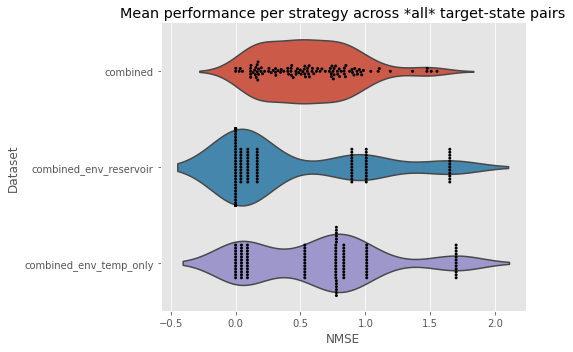

In [9]:
with plt.style.context('ggplot'):
  plot_data = data.loc[:, :, :, :].reset_index()
  plot_data['test_score'] *= -1

  g = sns.catplot(y="dataset", x="test_score", kind="violin", orient='h', data=plot_data, height=5, aspect=1.5, inner=None)
  sns.swarmplot(y="dataset", x="test_score", color="k", size=3, data=plot_data, ax=g.ax)
  g.set(title='Mean performance per strategy across *all* target-state pairs', ylabel='Dataset', xlabel='NMSE') 
  g.tight_layout()
  plt.show()

Score distribution per strategy for increasing percentile

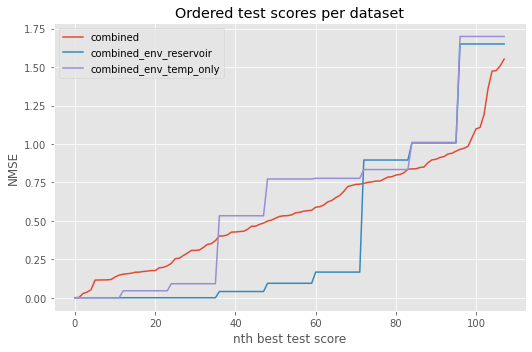

In [12]:
with plt.style.context('ggplot'):
  plt.figure(figsize=(5*1.5, 5))
  
  for dataset in datasets:
    plot_data = data.loc[:, :, dataset, :].reset_index()
    plot_data = plot_data.sort_values(by='test_score', ascending=False)
    plot_data['test_score'] *= -1
    plot_data = plot_data.reset_index()
    plt.plot(plot_data.index, plot_data['test_score'], label=dataset)

  plt.legend()
  plt.ylabel('NMSE')
  plt.xlabel('nth best test score')
  plt.title('Ordered test scores per dataset')
  plt.tight_layout()
    

C:\Users\Max\AppData\Local\Temp/ipykernel_38400/1029245349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['test_score'] *= -1
C:\Users\Max\AppData\Local\Temp/ipykernel_38400/1029245349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['train_mean'] *= -1


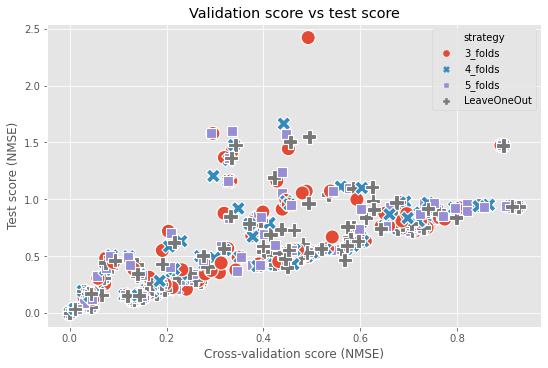

In [6]:
with plt.style.context('ggplot'):
  plot_data = data.loc[:, :, DATASET, :]
  plot_data['test_score'] *= -1
  plot_data['train_mean'] *= -1
  fig, ax = plt.subplots(1, 1, figsize=(1.5 * 5, 5), constrained_layout=True)
  sns.scatterplot(x='train_mean', y='test_score', hue='strategy', style='strategy', s=200, data=plot_data, ax=ax)
  ax.set_title('Validation score vs test score')
  ax.set_xlabel('Cross-validation score (NMSE)')
  ax.set_ylabel('Test score (NMSE)')

  # label outliers
  outlier_data = plot_data[plot_data['test_score'] > 5]

  def print_annotation(row):
    ax.text(row['train_mean'], row['test_score'], row['target'], rotation=0)

  outlier_data.apply(print_annotation, axis=1)

  plt.show()

In [7]:
print(data.groupby('strategy').median())

             test_score  train_mean  train_std   cv_mean    cv_std
strategy                                                          
3_folds       -0.544307   -0.314554   0.026188 -0.528018  0.079927
4_folds       -0.551212   -0.306130   0.021192 -0.498839  0.120770
5_folds       -0.547547   -0.327989   0.020068 -0.529677  0.178122
LeaveOneOut   -0.535202   -0.371226   0.013499 -2.346960  3.800500
